# Movie Revenue Forecast Tool

by Shijing Liu, Victor Zhu, and Xiaolong Zhu

# Step 1: Clean and train the dataset (~Run time: 3-4 minutes)

In [8]:
# SOURCE & REFERENCES
# https://www.kaggle.com/tmdb/tmdb-movie-metadata
# https://www.kaggle.com/sohier/tmdb-format-introduction
# https://www.kaggle.com/tanetboss/tmdb-classification-predict-hype-movie
# http://cs229.stanford.edu/proj2013/vanderMerweEimon-MaximizingMovieProfit.pdf
# https://www.analyticsvidhya.com/blog/2017/09/common-machine-learning-algorithms/

import json
import sys
import pandas as pd
import operator
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import widgets
%matplotlib inline

def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

# you need to change the path and / or file names here to run on your own computer

movies = load_tmdb_movies("../Desktop/tmdb_5000_movies.csv")
credits = load_tmdb_credits("../Desktop/tmdb_5000_credits.csv")

def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

# map directors 
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

# deal with keywords
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

# add cleaned data to the dataset
def clean_data(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['studio'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['keywords'] = tmdb_movies['keywords'].apply(pipe_flatten_names)
    return tmdb_movies

data = clean_data(movies, credits)

# remove irrelevant fields
data = data[['title','budget','revenue','genres',
                 'runtime','keywords','original_language',
                 'popularity','vote_count','vote_average',
                 'country','title_year','director_name',
                 'actor_name','studio']]

# get a list of sorted genres
genres = data['genres']
genre_list = []

for row in genres:
    split_genre = list(map(str, row.split('|'))) 
    for genre in split_genre:
        genre_list.append(genre)

# remove the empty value
feature_genres = list(set(genre_list))
del feature_genres[0]

# get a list of sorted keywords
keywords = data['keywords']
keyword_list = []

for row in keywords:
    split_keyword = list(map(str, row.split('|'))) 
    for keyword in split_keyword:
        keyword_list.append(keyword)    

# sort keywords
keywords = dict((s,keyword_list.count(s)) for s in set(keyword_list))
sorted_keywords = sorted(keywords.items(), key=operator.itemgetter(1), reverse=True)

feature_keywords = [x[0] for x in sorted_keywords]
del feature_keywords[0]

# select top 20 keywords
top_keywords = feature_keywords[0:20]

# get top directors and group them in different groups
directors = data['director_name']
directors = list(directors)

director = dict((s,directors.count(s)) for s in set(directors))
sorted_directors = sorted(director.items(), key=operator.itemgetter(1), reverse=True)

feature_directors = [x[0] for x in sorted_directors]
del feature_directors[0]

top_20_directors = feature_directors[0:19]
top_40_directors = feature_directors[20:39]
top_60_directors = feature_directors[40:59]
top_80_directors = feature_directors[60:79]
top_100_directors = feature_directors[80:99]

director_list = top_20_directors+ top_40_directors+ top_60_directors+ top_80_directors+ top_100_directors

# get top actors and group them in different groups
actors = data['actor_name']
actors = list(actors)

actor = dict((s,actors.count(s)) for s in set(actors))
sorted_actors = sorted(actor.items(), key=operator.itemgetter(1), reverse=True)

feature_actors = [x[0] for x in sorted_actors]
del feature_actors[0]

top_20_actors = feature_actors[0:19]
top_40_actors = feature_actors[20:39]
top_60_actors = feature_actors[40:59]
top_80_actors = feature_actors[60:79]
top_100_actors = feature_actors[80:99]

actor_list = top_20_actors+ top_40_actors+ top_60_actors+ top_80_actors+ top_100_actors

# get top studios and create 2 groups
studios = data['studio']
studios = list(studios)

studio = dict((s,studios.count(s)) for s in set(studios))
sorted_studios = sorted(studio.items(), key=operator.itemgetter(1), reverse=True)

feature_studios = [x[0] for x in sorted_studios]
del feature_studios[0]

top_20_studios = feature_studios[0:19]
top_50_studios = feature_studios[20:49]

studio_list = top_20_studios+ top_50_studios

# add genre, keyword, director, etc values to the dataset, 
# value will be 1 if the move is in this genre / director / actor / etc. , 0 if not

data['director_name'] = data['director_name'].astype(str)
data['actor_name'] = data['actor_name'].astype(str)
data['studio'] = data['studio'].astype(str)

# directors = data['director_name']
# actors = data['actor_name']
# studios = data['studio']

for genre in feature_genres:
    data[genre] = data['genres'].map(lambda s: 1 if genre in s else 0)

for keyword in top_keywords:
    data[keyword] = data['keywords'].map(lambda s: 1 if keyword in s else 0)
        
for director in directors:
    data['top_20_directors'] = data['director_name'].apply(lambda x: 1 if x in top_20_directors else 0)
    data['top_40_directors'] = data['director_name'].apply(lambda x: 1 if x in top_40_directors else 0)
    data['top_60_directors'] = data['director_name'].apply(lambda x: 1 if x in top_60_directors else 0)
    data['top_80_directors'] = data['director_name'].apply(lambda x: 1 if x in top_80_directors else 0)
    data['top_100_directors'] = data['director_name'].apply(lambda x: 1 if x in top_100_directors else 0)

for actor in actors:
    data['top_20_actors'] = data['actor_name'].apply(lambda x: 1 if x in top_20_actors else 0)
    data['top_40_actors'] = data['actor_name'].apply(lambda x: 1 if x in top_40_actors else 0)
    data['top_60_actors'] = data['actor_name'].apply(lambda x: 1 if x in top_60_actors else 0)
    data['top_80_actors'] = data['actor_name'].apply(lambda x: 1 if x in top_80_actors else 0)
    data['top_100_actors'] = data['actor_name'].apply(lambda x: 1 if x in top_100_actors else 0)

for studio in studios:
    data['top_20_studios'] = data['studio'].apply(lambda x: 1 if x in top_20_studios else 0)
    data['top_50_studios'] = data['studio'].apply(lambda x: 1 if x in top_50_studios else 0)

# drop non numerical features
df = data.drop(['title','genres','keywords','original_language','country','director_name','actor_name','studio','title_year'], axis = 1)

# remove rows with 0 revenue
df = df[data.revenue != 0]
#df = df.drop([''], axis=1)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split # to split the data into two parts

# get a list of features
features = list(df)
del features[1]

target = ['revenue']

#splitting data set into training and test data set in 0.7/0.3
train, test = train_test_split(df,test_size=0.30)

train = train.apply(pd.to_numeric, errors='coerce')
test = test.apply(pd.to_numeric, errors='coerce')

train.fillna("", inplace=True)
test.fillna("", inplace=True)

#Fill the training and test data with require information
X_train = train[features]
Y_train = train[target]
Y_train = Y_train.values.ravel()
X_test = test[features]
Y_test = test[target]

# Linear regression
from sklearn import linear_model # compute classification accuracy for the linear regression model

linear_model = linear_model.LinearRegression()
linear_model.fit(X_train, Y_train)
score = cross_val_score(linear_model, X_train, Y_train, cv=3)
score_linear_mean = score.mean()
score_linear_std = score.std()

# Random forest
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, Y_train)
score = cross_val_score(rfr_model, X_train, Y_train, cv=3)
score_rfr_mean = score.mean()
score_rfr_std = score.std()

# Step 2 : Enter user inputs through our interactive widgets below (Runtime ~ 1 minute)

In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#budget
w_budget = widgets.Text(    
    description='Budget:',)

def on_change(value):
    print (w_budget.value)

#runtime
w_runtime = widgets.Text(    
    description='Runtime:',)

def on_change(value):
    print (w_runtime.value)


#popularity
w_popularity = widgets.IntSlider(
    value=200,
    min=0,
    max=1000,
    step=50,
    description='Popularity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')

def on_change(value):
    print (w_popularity.value)

#vote_count
w_vote_count = widgets.IntSlider(
    value=5000,
    min=0,
    max=20000,
    step=500,
    description='Vote Count:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')

def on_change(value):
    print (w_vote_count.value)


# vote_average
w_vote_ave = widgets.FloatSlider(
    value=7.0,
    min=0,
    max=10.0,
    step=0.1,
    description='Vote Average:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

def on_change(value):
    print (w_vote_ave.value)


# genre dropdown
w_genre = widgets.Dropdown(
    options = feature_genres,
    value='Action',
    description='Genre:',)

def on_change(value):
    print (w_genre.value)

w_genre.observe(on_change,"value")

# keywords dropdown
w_keywords = widgets.Dropdown(
    options= top_keywords,
    value='woman director',    
    description='Keywords:',)

def on_change(value):
    print (w_keywords.value)
    
w_keywords.observe(on_change,"value")


# director dropdown
w_directors = widgets.Dropdown(
    options= director_list,
    value='Steven Spielberg',    
    description='Director:',)

def on_change(value):
    print (w_directors.value)

w_directors.observe(on_change,"value")


# actor dropdown
w_actors = widgets.Dropdown(
    options= actor_list,
    value='Ryan Gosling',    
    description='Actor:',)

def on_change(value):
    print (w_actors.value)

w_actors.observe(on_change,"value")


# Studio dropdown
w_studio = widgets.Dropdown(
    options= studio_list,
    value='Lions Gate Films',    
    description='Studio:',)

def on_change(value):
    print (w_studio.value)

w_studio.observe(on_change,"value")


display(w_budget)
display(w_runtime)
display(w_popularity)
display(w_vote_count)
display(w_vote_ave)
display(w_genre)
display(w_keywords)
display(w_directors)
display(w_actors)
display(w_studio)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

# Step 3: Print Predicted Revenue based on User Inputs in Step 2

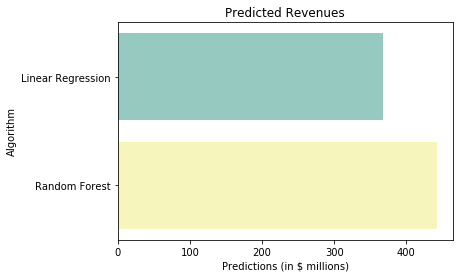

In [9]:
# get data from user inputs
test_genre = w_genre.value
test_kw = w_keywords.value
test_director = w_directors.value
test_actor = w_actors.value
test_studio = w_studio.value
test_vote_ave = w_vote_ave.value
test_budget = w_budget.value
test_runtime = w_runtime.value
test_popularity = w_popularity.value
test_vote_count = w_vote_count.value

# create a dummy test dataset here
labels = list(X_test)

test_df = pd.DataFrame(columns=labels)
test_data = [0] * len(labels)

test_df.loc[0] = test_data

# input budget
budget_index = labels.index("budget")
test_data[budget_index] = test_budget

# input runtime
runtime_index = labels.index("runtime")
test_data[runtime_index] = test_runtime

# input popularity
popularity_index = labels.index("popularity")
test_data[popularity_index] = test_popularity

# input vote_count
vote_count_index = labels.index("vote_count")
test_data[vote_count_index] = test_vote_count

# input vote_average
vote_average_index = labels.index("vote_average")
test_data[vote_average_index] = test_vote_ave

# input genre
if test_genre in labels:
    genre_index = labels.index(test_genre)
    test_data[genre_index] = 1

# input key words
if test_kw in keyword_list:
    key_words_index = labels.index(test_kw)
    test_data[key_words_index] = 1

# input directors
if test_director in top_20_directors:
    director_index = labels.index("top_20_directors")
    test_data[director_index] = 1
elif test_director in top_40_directors:
    director_index = labels.index("top_40_directors")
    test_data[director_index] = 1
elif test_director in top_60_directors:
    director_index = labels.index("top_60_directors")
    test_data[director_index] = 1
elif test_director in top_80_directors:
    director_index = labels.index("top_80_directors")
    test_data[director_index] = 1
elif test_director in top_100_directors:
    director_index = labels.index("top_100_directors")
    test_data[director_index] = 1

# input actors
if test_actor in top_20_actors:
    actor_index = labels.index("top_20_actors")
    test_data[actor_index] = 1
elif test_actor in top_40_actors:
    actor_index = labels.index("top_40_actors")
    test_data[actor_index] = 1
elif test_actor in top_60_actors:
    actor_index = labels.index("top_60_actors")
    test_data[actor_index] = 1
elif test_actor in top_80_actors:
    actor_index = labels.index("top_80_actors")
    test_data[actor_index] = 1
elif test_actor in top_100_actors:
    actor_index = labels.index("top_100_actors")
    test_data[actor_index] = 1

# input studios
if test_studio in top_20_studios:
    studio_index = labels.index("top_20_studios")
    test_data[studio_index] = 1
elif test_studio in top_50_studios:
    studio_index = labels.index("top_50_studios")
    test_data[studio_index] = 1

test_df.loc[0] = test_data
    
test_df = test_df.apply(pd.to_numeric, errors='coerce')


# make predictions
linear_predicted = int(linear_model.predict(test_df)/1000000)
rfr_predicted = int(rfr_model.predict(test_df)/1000000)

# print ("Predicted box office:", rfr_predicted, "million USD")

predictions = []
predictions.append(linear_predicted)
predictions.append(rfr_predicted)

# print(predictions)

new_data = pd.DataFrame({"Predictions":predictions,"Algorithm":["Linear Regression","Random Forest"]})

# print(new_data)

g = sns.barplot("Predictions","Algorithm",data = new_data, palette="Set3",orient = "h")
g.set_xlabel("Predictions (in $ millions)")
g = g.set_title("Predicted Revenues")

# Conclusion : Random Forest and Linear Regression offers higher predictibility than the other algorithms we tested

# Appendix - Codes for Logistic, SVM, Naives Bayes, Decision Tree

In [10]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logr_model = LogisticRegression()
logr_model.fit(X_train, Y_train)
score = cross_val_score(logr_model, X_train, Y_train, cv=3)
score_logr_mean = score.mean()
score_logr_std = score.std()


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [11]:
# Support Vector Machine
from sklearn import svm

svm_model = svm.SVC()
svm_model.fit(X_train, Y_train)
score = cross_val_score(svm_model, X_train, Y_train, cv=3)
score_svm_mean = score.mean()
score_svm_std = score.std()

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [12]:
# Native Bayes modelfrom sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()
gnb_model.fit(X_train, Y_train)
score = cross_val_score(gnb_model, X_train, Y_train, cv=3)
score_gnb_mean = score.mean()
score_gnb_std = score.std()

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [13]:
# decision tree
from sklearn import tree

dt_model = tree.DecisionTreeClassifier( max_depth=10, min_samples_leaf=5)
dt_model.fit(X_train, Y_train)
score = cross_val_score(dt_model, X_train, Y_train, cv=3)
score_dt_mean = score.mean()
score_dt_std = score.std()

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


# Comparision Report 

In [14]:
means = []
means.append(score_linear_mean)
means.append(score_logr_mean)
means.append(score_rfr_mean)
means.append(score_svm_mean)
means.append(score_gnb_mean)
means.append(score_dt_mean)

stds = []
stds.append(score_linear_std)
stds.append(score_logr_std)
stds.append(score_rfr_std)
stds.append(score_svm_std)
stds.append(score_gnb_std)
stds.append(score_dt_std)

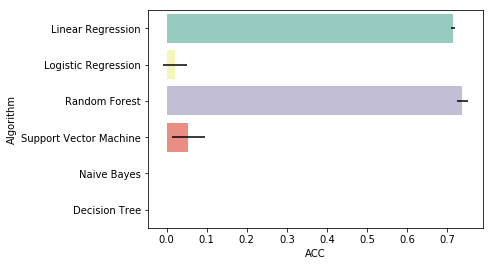

In [15]:
comparison = pd.DataFrame({"ACC":means,"Std":stds,"Algorithm":["Linear Regression","Logistic Regression","Random Forest","Support Vector Machine","Naive Bayes","Decision Tree"]})
comparison["Type"]= "CrossValid"
sns.barplot("ACC","Algorithm",data = comparison, palette="Set3",orient = "h",**{'xerr':stds})
# comp_g.set_xlabel("Mean Accuracy")
# comp_g = comp_g.set_title("Cross validation scores")